In [305]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [306]:
# 理論解の計算
def analytical_solution(m, c, k, u0, v0, delta_t, num_steps):
    omega_n = np.sqrt(k / m)  # 自然振動数
    zeta = c / (2 * np.sqrt(m * k))  # 減衰比
    omega_d = omega_n * np.sqrt(1 - zeta**2)  # 減衰振動数

    time = np.linspace(0, delta_t * num_steps, num_steps)
    displacement = np.exp(-zeta * omega_n * time) * (u0 * np.cos(omega_d * time) + (v0 + zeta * omega_n * u0) / omega_d * np.sin(omega_d * time))
    velocity = np.gradient(displacement, delta_t)
    acceleration = np.gradient(velocity, delta_t)
    
    return time, displacement, velocity, acceleration

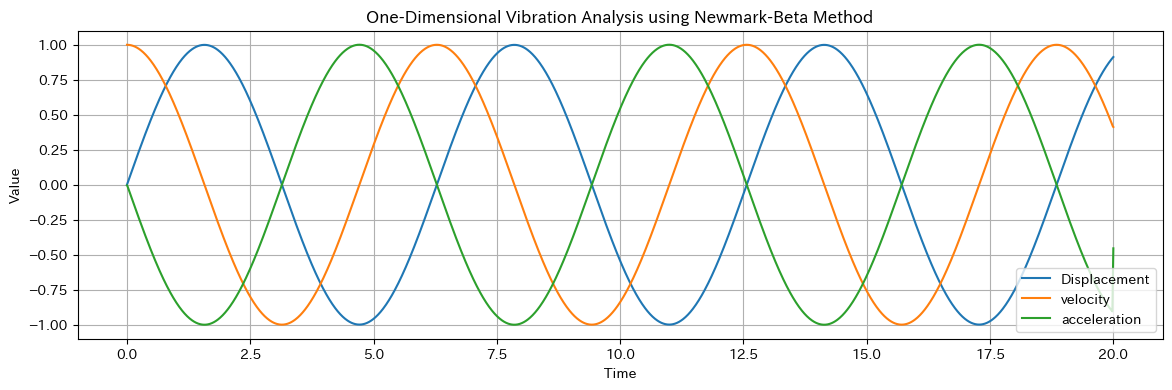

0.9999999999402227


In [307]:
# パラメータと初期条件の設定
m = 1.0  # 質量
c = 0.0  # 減衰係数
k = 1.0  # 剛性
u0 = 0.0  # 初期変位
v0 = 1.0  # 初期速度
delta_t = 0.01  # 時間刻み幅
num_steps = 2000  # 計算ステップ数

# 結果のプロット
plt.figure(figsize=(14, 4))

# 理論解
time, displacement, velocity, acceleration = analytical_solution(m, c, k, u0, v0, delta_t, num_steps)
plt.plot(time, displacement, label='Displacement')
plt.plot(time, velocity, label='velocity')
plt.plot(time, acceleration, label='acceleration')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('One-Dimensional Vibration Analysis using Newmark-Beta Method')
plt.legend()
plt.grid(True)
plt.show()

print(displacement.max())

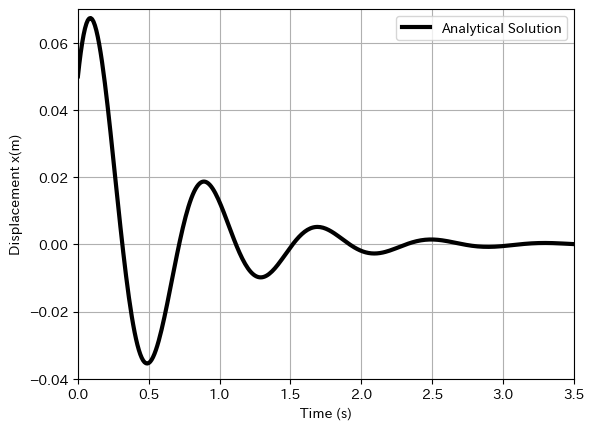

In [308]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

cSimSettings = {
    "SIM_START": 0.0,
    "SIM_END": 5.0,
    "SIM_STEP": 0.01,
}

cMdlParams = {
    "M": 5.0,
    "C": 16.0,
    "K": 320.0,
    "X0": 0.05,         # 初期変位
    "V0": 0.4,          # 初期速度
    "A0": 0.0,
    "F": 0.0,
}

cNewmarkParams = {
    "BETA": 1.0/6.0
}


def calcAnalyticalSolution(t):
    # モデルパラメータ設定
    m = cMdlParams["M"]
    c = cMdlParams["C"]
    k = cMdlParams["K"]
    v0 = cMdlParams["V0"]
    x0 = cMdlParams["X0"]
    # 振動パラメータ計算
    wn = np.sqrt(k/m)                            # 不減衰固有角振動数
    zeta = c/(2.0*np.sqrt(m*k))                  # 減衰比
    wd = np.sqrt(1-zeta**2)*wn                   # 減衰固有角振動数
    # 解の計算
    Amp = np.sqrt((x0**2 + ((zeta*wn*x0 + v0)/wd)**2))
    phi = np.arctan((zeta*wn*x0 + v0)/(x0*wd))
    x = Amp*np.exp(-zeta*wn*t)*np.cos(wd*t - phi)
    return x


def definiteSolverNewmarkBeta():
    # 代数計算用シンボル定義
    m, c, k = sp.symbols('m, c, k')
    an, vn, xn = sp.symbols('an, vn, xn')
    an1, vn1, xn1, fn1 = sp.symbols('an1, vn1, xn1, fn1')
    dt, beta = sp.symbols('dt, beta')

    # (t+Δt)時点で満たすべき1次元振動モデルの運動方程式の定義
    eqm = m*an1 + c*vn1 + k*xn1 - fn1
    eqm = sp.lambdify((vn1, xn1), eqm, "numpy")  # 速度と位置を変数化

    # 速度と位置の数値積分式の定義
    vn1 = vn + dt*(an + an1)/2
    xn1 = xn + dt*vn + dt**2/2*an + beta*dt**2*(an1 - an)

    # 運動方程式に代入して加速度について解く
    fan1 = eqm(vn1, xn1)
    fan1 = sp.solve(fan1, an1)[0]  # 配列形式となって返ってきたため要素を取り出すために[0]を追加

    # 加速度、速度、位置の計算関数化
    an1_solver = sp.lambdify((m,c,k,xn,vn,an,fn1,dt,beta), fan1, "numpy")
    vn1_solver = sp.lambdify((vn,an,an1,dt), vn1, "numpy")
    xn1_solver = sp.lambdify((xn,vn,an,an1,dt,beta), xn1, "numpy")
    
    return(an1_solver, vn1_solver, xn1_solver)


def solverNewmarkBeta(m,c,k,xn,vn,an,fn1,dt,beta):
    an1_num = fn1 - c*(vn + dt*an/2.0) - k*(xn + dt*vn + (1.0/2.0 - beta)*(dt**2)*an)
    an1_den = m + dt*c/2.0 + beta*(dt**2)*k
    an1 = an1_num/an1_den
    vn1 = vn + dt*(an + an1)/2.0
    xn1 = xn + dt*vn + (dt**2)*an/2.0 + beta*(dt**2)*(an1 - an)
    return(an1, vn1, xn1)


if __name__ == "__main__":
    # 変数準備(固定ステップで計算するためあらかじめ用意しておく)
    sim_start = cSimSettings["SIM_START"]
    sim_end = cSimSettings["SIM_END"]
    sim_step = cSimSettings["SIM_STEP"]
    num_step = int((sim_end-sim_start)/sim_step) + 1
    t = np.linspace(sim_start, sim_end, num_step)

    # 数値計算の格納結果
    a_nms = np.zeros(num_step)
    v_nms = np.zeros(num_step)
    x_nms = np.zeros(num_step)
    a_nm = np.zeros(num_step)
    v_nm = np.zeros(num_step)
    x_nm = np.zeros(num_step)

    # 解析解の計算
    num_step = int((sim_end-sim_start)/0.01) + 1
    ta = np.linspace(sim_start, sim_end, num_step)
    x = calcAnalyticalSolution(ta)

    # 数値計算による解
    a0 = cMdlParams["A0"]
    v0 = cMdlParams["V0"]
    x0 = cMdlParams["X0"]
    m = cMdlParams["M"]
    c = cMdlParams["C"]
    k = cMdlParams["K"]
    f = cMdlParams["F"]
    dt = sim_step
    b = cNewmarkParams["BETA"]
    calc_an1, calc_vn1, calc_xn1 = definiteSolverNewmarkBeta()
    for i in range(t.size):
        if (i < 1):
            # 初期値
            [a_nms[i], v_nms[i], x_nms[i]] = [a0, v0, x0]
            [a_nm[i], v_nm[i], x_nm[i]] = [a0, v0, x0]
        else:
            # シンボル計算で作成したニューマークβ法による計算
            a_nms[i] = calc_an1(m,c,k,x_nms[i-1],v_nms[i-1],a_nms[i-1],f,dt,b)
            v_nms[i] = calc_vn1(v_nms[i-1],a_nms[i-1],a_nms[i],dt)
            x_nms[i] = calc_xn1(x_nms[i-1],v_nms[i-1],a_nms[i-1],a_nms[i],dt,b)
            # ニューマークβ法による計算
            a_nm[i],v_nm[i], x_nm[i] = solverNewmarkBeta(m,c,k,
                                                         x_nm[i-1],
                                                         v_nm[i-1],
                                                         a_nm[i-1],
                                                         f,dt,b)

    # グラフ確認
    plt.plot(ta, x, 'k', lw=3.0, label='Analytical Solution')
    # plt.plot(t, x_nms, 'g', lw=2.0, label='Newmark-β method(Symbolic)')
    # plt.plot(t, x_nm, 'r--', lw=1.0, label='Newmark-β method')
    plt.xlim(0, 3.5)
    plt.ylim(-0.04, 0.07)
    plt.xlabel('Time (s)')
    plt.ylabel('Displacement x(m)')
    plt.legend()
    plt.grid()
    plt.show()
    #plt.savefig("./1dofVibSim_Newmarkbeta.png")


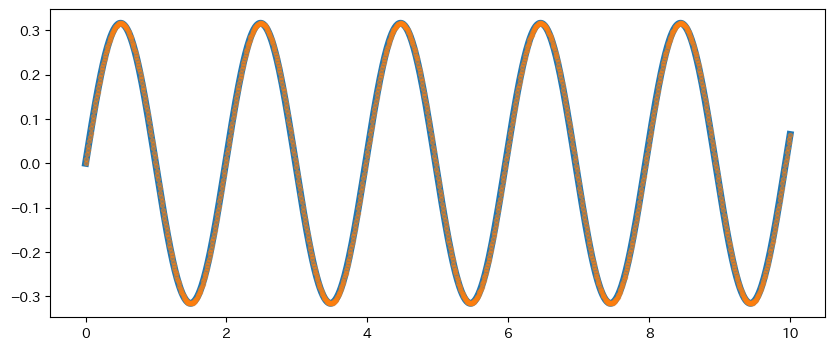

-0.0 3.1622776601683795


In [392]:
def calcAnalyticalSolution(t, m, c, k, v0, x0):
    # 振動パラメータ計算
    wn = np.sqrt(k / m)  # 不減衰固有角振動数
    zeta = c / (2.0 * np.sqrt(m * k))  # 減衰比
    wd = np.sqrt(1 - zeta**2) * wn  # 減衰固有角振動数
    # 解の計算
    Amp = np.sqrt((x0**2 + ((zeta * wn * x0 + v0) / wd) ** 2))
    phi = np.arctan((zeta * wn * x0 + v0) / (x0 + 0.000001 * wd))
    x = Amp * np.exp(-zeta * wn * t) * np.cos(wd * t - phi)
    
    return x, wn, wd


def solverNewmarkBeta(m, c, k, xn, vn, an, fn1, dt, beta):
    an1_num = (fn1 - c * (vn + dt * an / 2.0) - k * (xn + dt * vn + (1.0 / 2.0 - beta) * (dt**2) * an))
    an1_den = m + dt * c / 2.0 + beta * (dt**2) * k
    an1 = an1_num / an1_den
    vn1 = vn + dt * (an + an1) / 2.0
    xn1 = xn + dt * vn + (dt**2) * an / 2.0 + beta * (dt**2) * (an1 - an)
    return (an1, vn1, xn1)

m = 1.0  # 質量
c = 0.0  # 減衰係数
k = 10.0  # 剛性
x0 = 0.0  # 初期変位
v0 = 1.0  # 初期速度
a0 = (-c * v0 - k * u0) / m
f = 0.0

omega_n = np.sqrt(k/m)

beta = 1/6
dt = 0.01
sim_start = 0
sim_end = 10.0
num_step = int((sim_end - sim_start) / dt) + 1
t = np.linspace(sim_start, sim_end, num_step)


# 解析解の計算
# num_step = int((sim_end - sim_start) / 0.01) + 1
x, wn, wd = calcAnalyticalSolution(t, m, c, k, v0, x0)

# ニューマークβ法による計算
a_nm = np.zeros(num_step)
v_nm = np.zeros(num_step)
x_nm = np.zeros(num_step)

for i in range(t.size):
    if (i < 1):
        # 初期値
        [a_nms[i], v_nms[i], x_nms[i]] = [a0, v0, x0]
        [a_nm[i], v_nm[i], x_nm[i]] = [a0, v0, x0]
    else:
        a_nm[i],v_nm[i], x_nm[i] = solverNewmarkBeta(m, c, k, x_nm[i-1], v_nm[i-1], a_nm[i-1], f, dt, beta)

fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(t, x, "-", lw=5.0, label="Analytical Solution", alpha=1)
plt.plot(t, x_nm, '.', lw=1.0, label='Newmark-β method', alpha=0.5)
plt.show()

print(a0, wn)

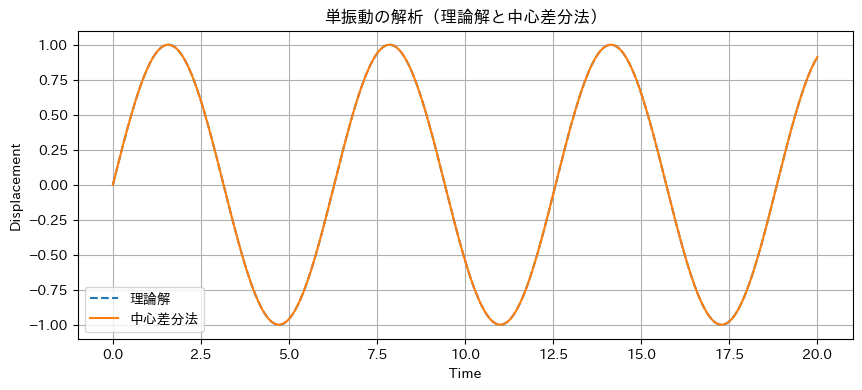

最大変位（理論解）：0.9999999998313446
最大変位（中心差分法）：1.0000001248244548


In [402]:
import numpy as np
import matplotlib.pyplot as plt

def analytical_solution(m, k, u0, v0, delta_t, num_steps):
    omega_n = np.sqrt(k / m)  # 自然振動数
    time = np.linspace(0, delta_t * (num_steps - 1), num_steps)
    displacement = u0 * np.cos(omega_n * time) + (v0 / omega_n) * np.sin(omega_n * time)
    return time, displacement

def central_difference_method(m, k, u0, v0, delta_t, num_steps):
    # 初期条件
    u = np.zeros(num_steps)
    v = np.zeros(num_steps)
    a = np.zeros(num_steps)
    
    u[0] = u0
    v[0] = v0
    a[0] = -k / m * u[0]
    
    # 初期の変位を次のステップに予測
    u[1] = u[0] + delta_t * v[0] + 0.5 * delta_t**2 * a[0]
    
    for i in range(1, num_steps - 1):
        a[i] = -k / m * u[i]
        u[i + 1] = 2 * u[i] - u[i - 1] + delta_t**2 * a[i]
    
    time = np.linspace(0, delta_t * (num_steps - 1), num_steps)
    return time, u

# パラメータと初期条件の設定
m = 1.0  # 質量
k = 1.0  # 剛性
u0 = 0.0  # 初期変位
v0 = 1.0  # 初期速度
delta_t = 0.001  # 時間刻み幅
num_steps = 20000  # 計算ステップ数

plt.figure(figsize=(10, 4))

# 理論解
time, displacement_theoretical = analytical_solution(m, k, u0, v0, delta_t, num_steps)
plt.plot(time, displacement_theoretical, label='理論解', linestyle='--')

# 中心差分法による計算
time, displacement_cd = central_difference_method(m, k, u0, v0, delta_t, num_steps)
plt.plot(time, displacement_cd, label='中心差分法')

# プロット設定
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title('単振動の解析（理論解と中心差分法）')
plt.legend()
plt.grid(True)
plt.show()

print(f"最大変位（理論解）：{displacement_theoretical.max()}")
print(f"最大変位（中心差分法）：{displacement_cd.max()}")
